In [1]:
%pylab inline
import glob
import os.path as op
import seaborn as sns
datapath = "/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/**/**"


Populating the interactive namespace from numpy and matplotlib


In [2]:
fnvideos = glob.glob(op.join(datapath, "*"))
print(fnvideos)

['/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2016_04_23/IMAG0022.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2016_04_23/IMAG0018.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2016_04_23/IMAG0016.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2016_04_23/IMAG0004.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2016_04_23/IMAG0006.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2017_04_10/IMAG0126.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2017_04_10/IMAG0042.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2017_04_10/IMAG0120.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2017_04_10/IMAG0124.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2016_11_29/IMAG0073.AVI', '/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/20

In [3]:
filtered_activity_image_threshold = 0.1

# Background model extraction

/home/mjirik/data/lynx_lynx/fotopasti_20170825/videa/s rysem/lok3/2016_04_23/IMAG0004.AVI


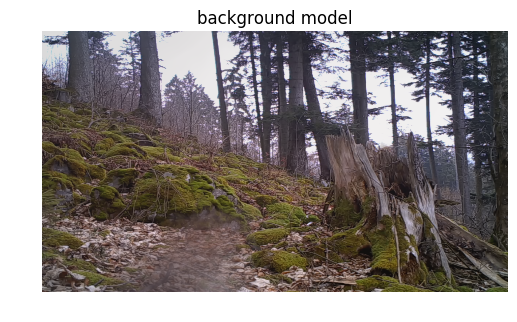

In [4]:
import imageio
import skimage
import numpy as np
ivideo = 10
ivideo = 3
fn = fnvideos[ivideo]
print(fn)
vid = imageio.get_reader(fn)

def create_background_model(vid,  begin_offset=1, end_offset=50, step=10):
    
    vid_len = vid.get_length() - end_offset - begin_offset
    frame_size = vid.get_meta_data()["size"]

    background_model = np.zeros([frame_size[1], frame_size[0], 3])

    nums = range(begin_offset, vid.get_length() - end_offset, step)

    # nums = [1,5, 10]

    processed_images = 0
    for num in nums:
        image = vid.get_data(num).astype(double)
        if processed_images == 0:
            background_model = image
        else:
            background_model = (processed_images * background_model)/(processed_images + 1.) + image/(processed_images + 1.)
        processed_images += 1
        
    return background_model, frame_size
#     fig = pylab.figure()
#     fig.suptitle('image #{}'.format(num), fontsize=20)
#     pylab.imshow(image)
background_model, frame_size = create_background_model(vid)
fig = pylab.figure()
plt.title('background model')
# print(np.min(image), np.max(image))
pylab.imshow(background_model.astype(np.uint8))
plt.axis("off")
# plt.colorbar()
pylab.show()

# Activity estimation

In [5]:
import datetime


In [6]:
def activity_estimation(vid, background_model, begin_offset=1, end_offset=10, step=1):
    error = []

    fps = vid.get_meta_data()['fps']
    nums = range(begin_offset, vid.get_length() - end_offset, step)

    # times = []
    errmax = 255*3*np.prod(frame_size)
#     print(errmax)
    for num in nums:
    #     print(num)
        image = vid.get_data(num).astype(double)
        err = np.sum(np.abs(background_model - image))
        error.append(err)
        
    time = np.asarray(nums)/fps
    error = np.array(error) / errmax
    return error, time, errmax

import skimage.filters
from skimage.morphology import disk

def get_max_image(vid, error, begin_offset=1):
    imax = np.argmax(error)
    image = get_image(vid, imax, begin_offset)
    return image, imax

def get_image(vid, imax, begin_offset=1):
    return vid.get_data(imax + begin_offset)

def plt_activity(time, error):
    plt.semilogy(time, 100*(error))
    # plt.ylim(base, 1+base)
    plt.ylim(1, 100)
    plt.xlabel("time [s]")
    plt.ylabel("activity [%]")
    
def get_activity_diff_image(image, background_model, safety_multiplicator=0.99):
    diff = np.abs(image.astype(double) - background_model.astype(double))
    errim = (diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2)**0.5
    # normaliza to range <0 ; 1>
    # sqrt(3) because of 3 color channels
    errim = safety_multiplicator * errim / (255. * np.sqrt(3))
    return errim

def activity_time_filter(
    vid, iframe, 
    begin_offset = 1, end_offset = 50,  around_imax = range,  time_range = 5):

    around_mn = int(max(begin_offset, round(iframe- (time_range / 2))))
    around_mx = int(min(vid.get_length() - end_offset, round(iframe + (time_range / 2))))

    around_range = range(around_mn, around_mx, 10)

    frames = np.zeros([image.shape[0], image.shape[1], len(around_range)])

    for i, iiframe in enumerate(around_range):
    #     print(i, iframe)
        frames[:, :, i] = get_activity_diff_image(get_image(vid, iiframe, begin_offset=begin_offset), background_model)
    #     plt.figure()
    #     plt.imshow(frames[:,:,i])

    time_mean_frame = np.mean(frames, axis=2) 
    return time_mean_frame

def activity_space_filter(time_mean_frame, median_disk_radius=15, gaussian_sigma=5.0):
    mn = np.min(time_mean_frame)
    print("limits ", mn, np.max(time_mean_frame))
    if mn < -1:
        time_mean_frame = time_mean_frame - mn
#     if np.min(time_mean_frame) < 0:
        

    # mean_frame_filtered = skimage.filters.gaussian(mean_frame, sigma=5.0)
    mean_frame_filtered = skimage.filters.median(time_mean_frame, disk(median_disk_radius))
    mean_frame_filtered = skimage.filters.gaussian(mean_frame_filtered, sigma=gaussian_sigma)
    return mean_frame_filtered

#     times.append(datetime.timedelta(seconds=(num/fps)))
    
# plt.plot(np.asarray(num)/fps, error)

In [7]:

error, time, errmax = activity_estimation(vid, background_model)

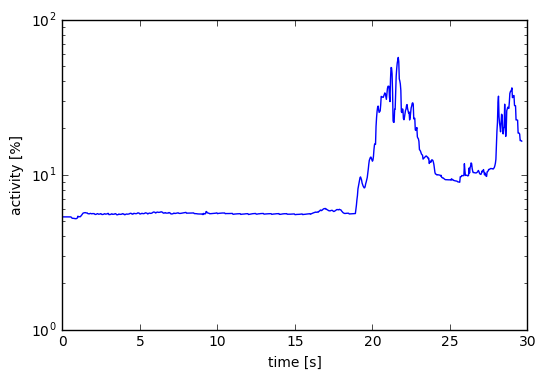

In [8]:


# base = 1
# plt.figure()
# plt.plot(np.asarray(nums)/fps, log(base +(error / plotmax)))
# plt.ylim(log(base), log(1+base))
plt.figure()

plt_activity(time, error)


# Maxium activity frame

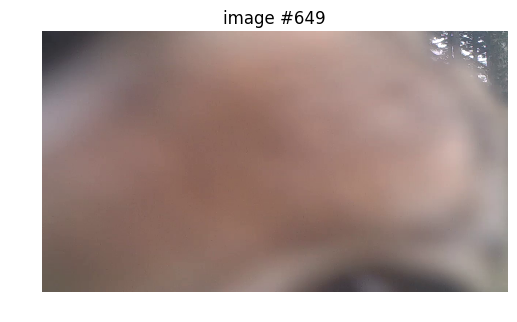

In [9]:
image, imax = get_max_image(vid, error)
plt.imshow(image)
plt.axis("off")
plt.title('image #{}'.format(imax))

## Maxium activity localization

(-0.5, 1279.5, 719.5, -0.5)

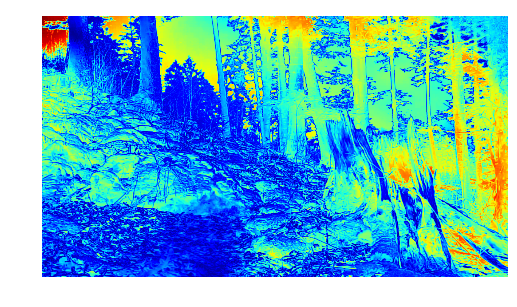

In [10]:
err_threshold = 0.00000000001
# > err_threshold * 255**3
errim = get_activity_diff_image(image, background_model)
plt.imshow(errim)
plt.axis("off")

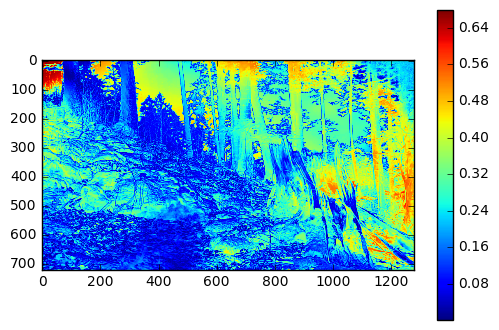

In [11]:

time_mean_frame = activity_time_filter(vid, imax)
plt.imshow(time_mean_frame)
plt.colorbar()
    
# np.min(mean_frame)
# np.max(mean_frame)

In [12]:
# np.min(frames)

('limits ', 0.0014412292658262454, 0.67877382126106844)


/home/mjirik/miniconda2/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


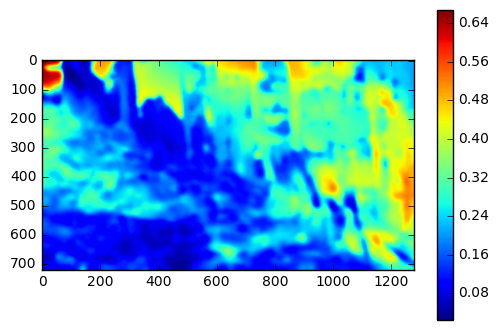

In [13]:

mean_frame_filtered = activity_space_filter(time_mean_frame)
plt.imshow(mean_frame_filtered)
plt.colorbar()
# import scikits

In [14]:
def activity_filter_time_and_space(vid, iframe):
    im = activity_time_filter(vid, iframe)
    im = activity_space_filter(im)
    return im

In [15]:
def roi_size(roi_min, roi_max):
    roi_y_size = roi_max[0] - roi_min[0]
    roi_x_size = roi_max[1] - roi_min[1]
    roi_size = [roi_y_size, roi_x_size]
    return roi_size
    
def activity_roi(mean_frame_filtered,  cut_border = 40, activity_threshold=filtered_activity_image_threshold):
    binary_activity_frame = mean_frame_filtered > activity_threshold
    x, y = np.nonzero(binary_activity_frame)
    if len(x) == 0:
        return None
    roi_min = [
        max(np.min(y) - cut_border, 0), 
        max(np.min(x) - cut_border, 0)
    ]
    roi_max = [
        min(np.max(y) + cut_border, mean_frame_filtered.shape[1]),
        min(np.max(x) + cut_border, mean_frame_filtered.shape[0]),

    ]
    return roi_min, roi_max 

roi = activity_roi(mean_frame_filtered)

# imshow(frames[:,:,0] - frames[:,:,-1])

In [16]:
image.shape

(720, 1280, 3)

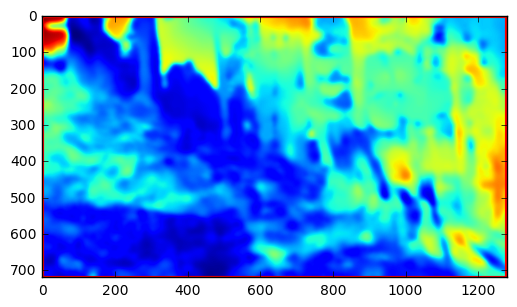

In [17]:
import matplotlib.patches as patches

def show_roi(roi_min, roi_max=None, roi_size=None, image=None):
    if roi_size is None:
        roi_y_size = roi_max[0] - roi_min[0]
        roi_x_size = roi_max[1] - roi_min[1]
        roi_size = [roi_y_size, roi_x_size]
    ax = plt.gca()
    if image is not None:
        plt.imshow(image)
    # plt.imshow(binary_activity_frame)

    ax.add_patch(
        patches.Rectangle(
            roi_min,
    #         (10, 10),
            roi_size[0],
            roi_size[1],
            fill=False,      # remove background
            edgecolor="red",
            linewidth=3
        )
    )
    
if roi is not None:
    show_roi(*roi, image=mean_frame_filtered)
# ax.add_patch(
#     patches.Rectangle(
#         pt_max,
# #         (10, 10),
#         10,
#         10,
#         fill=False,      # remove background
#         edgecolor="red",
#         linewidth=3
#     )
# )

In [18]:
frame = get_image(vid, imax)
if roi is not None:
    show_roi(roi, image=frame)

TypeError: 'NoneType' object has no attribute '__getitem__'

In [ ]:
def crop_frame(frame, roi_min, roi_max):
    return frame[
        roi_min[1]:roi_max[1],
        roi_min[0]:roi_max[0],
        :
    ]
if roi is not None:
    frame_cropped = crop_frame(frame, *roi)
    plt.imshow(frame_cropped)


In [ ]:


def data_processing(fn):
    vid = imageio.get_reader(fn)
    background_model, frame_size = create_background_model(vid)
    error, time, errmax = activity_estimation(vid, background_model)
    frame, iframe= get_max_image(vid, error)
    errim = get_activity_diff_image(frame, background_model)
    #     return background_model, error, time, errmax, image, imax
    filtered_activity = activity_filter_time_and_space(vid, iframe)
    roi = activity_roi(filtered_activity)
    if roi is not None:
        cropped_frame = crop_frame(frame, *roi)
    
        

    # def visualization(vid, background_model, error, time, errmax):
    plt.subplot(321)
    pylab.imshow(background_model.astype(np.uint8))
    plt.axis("off")
    plt.title("background model")
    # plt.colorbar()
    
    plt.subplot(322)
    plt_activity(time, error)
    
    plt.subplot(323)
    plt.imshow(frame)
    plt.axis("off")
    plt.title('image #{}'.format(imax))
    
    plt.subplot(324)
    plt.imshow(errim)
    plt.axis("off")
    plt.title("difference image")
    
    plt.subplot(325)
    plt.imshow(filtered_activity)
    plt.colorbar()
    if roi is not None:
        show_roi(*roi)
#     plt.imshow()
    plt.axis("off")
    plt.title("filtered activity and ROI")
    
    plt.subplot(326)
#     show_roi(roi_min, roi_size, image=filtered_activity)
    if roi is not None:
        plt.imshow(cropped_frame)
    plt.axis("off")
    plt.title("Activity crop")
    
    plt.suptitle(fn)


In [ ]:
# data_processing(fn)